## Домашнее задание по свёрточным сетям

Сутью домашнего задания является последовательная реализация базовых операций, применяемых в свёрточных сетях с использованием операций над тензорами PyTorch, но без применения модулей torch.nn. Студенты должны самостоятельно реализовать как прямой и обратный проходы слоёв, так и классы нейронных сетей.

Правильность выполнения задания будет проверяться идентичностью прохождения процесса обучения в тех же архитектурах, выполненных с применением модулей и алгоритмов PyTorch.

### Задание 1

В первом задании требуется реализовать классы двухмерной свёртки **Conv**, линейного слоя **Fc**, алгоритм обучения нейронной сети **SGD**, функцию активации **ReLU**, **Softmax** и функцию эмпирического риска **CrossEntropyLoss**.

Свёрточные и полносвязные слои должны реализовывать операцию сдвига (*bias*, *b*). 
Сверить формулы прямого прохода можно в документации по [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) и [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

Далее, следует реализовать класс модели, который включает в себя реализованные выше компоненты. Требуется повторить параметры обучения и архитектуру, реализованную ниже с помощью torch.nn модулей. Критерием правильности решения будет совпадение значений эмпирического риска при обучении обеих реализаций сетей на одних и тех же данных, с теми же параметрами и с одинаковыми начальными инициализациями весов.

Данные для обучения состоят из 4 примеров вертикальных и горизонтальных линий. 


In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
import math
import copy

_ = torch.manual_seed(1)

In [2]:
def one_hot_encoding(y, num_classes):
    N = y.shape[0]
    Z = torch.zeros((N, num_classes))
    Z[torch.arange(N), y] = 1
    return Z

Train data shape [Batch, Channels, Height, Width] = torch.Size([4, 1, 5, 5])
Labels shape = torch.Size([4])
Mean and standard deviation before normalization = 49.90, 97.45
Mean and standard deviation after normalization = 0.00, 1.00
Train batch


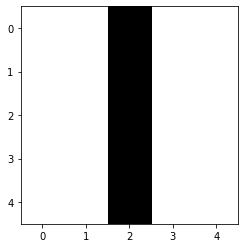

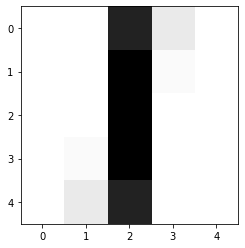

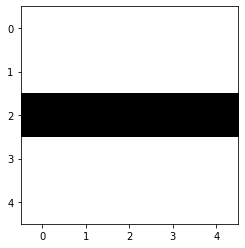

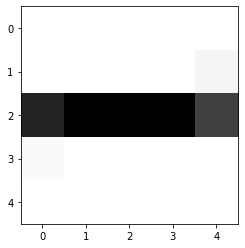

In [3]:
# Обучение будет вестись на следующих данных
def get_data():
    # Задача классификации вертикальных и горизонтальных линий
    # Данные
    vert1 = [[0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0]]

    vert2 = [[0, 0, 220, 40, 0],
             [0, 0, 250, 10, 0],
             [0, 0, 250, 0, 0],
             [0, 10, 250, 0, 0],
             [0, 40, 220, 0, 0]]

    hor1 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [250, 250, 250, 250, 250],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

    hor2 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 20],
            [220, 250, 250, 250, 200],
            [10, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

    data = [vert1, vert2, hor1, hor2]
    labels = [0, 0, 1, 1]
    
    train_x = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
    labels = torch.tensor(labels, dtype=torch.long)

    return train_x, labels

train_x, labels = get_data()
print(f'Train data shape [Batch, Channels, Height, Width] = {train_x.shape}')
print(f'Labels shape = {labels.shape}')


train_mean = torch.mean(train_x)
train_std = torch.std(train_x)
batch = (train_x - train_mean) / train_std

print(f'Mean and standard deviation before normalization = {train_mean.item():.2f}, {train_std.item():.2f}')
print(f'Mean and standard deviation after normalization = {torch.mean(batch).item():.2f}, {torch.std(batch).item():.2f}')

print('Train batch')
for img in batch:
    plt.imshow(img.squeeze(0), cmap='Greys')  # Цвета инвертированы. Чем темнее, тем значение пикселя больше
    plt.show() 

Реализуем эталонную модель **TorchGradientModel**, состоящую из следующих модулей:
- Сверточный слой с 4 фильтрами размера $5\times5$;
- Функция активации [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Линейный слой с 2 выходными нейронами для классов горизонтальной и вертикальной линий

Вопрос:
Каким ещё образом можно осуществить бинарную классификацию, не используя линейный слой, с 2 выходными нейронами?

**Ответ.** Можно подобрать размер свёрток так, чтобы на выходе получалось два канала, в каждом из которых будет тензор вероятности принадлежности к классам (в нашем случае детекция не нужна, поэтому достаточно на выходе получить 2 тензора размера 1 на 1, то есть output.shape = 2x1x1).

А ещё можно попробовать с одним нейроном: применять какую-нибудь сигмоиду и смотреть, если значение > 0.5, то отправляем в класс 1, иначе --- в класс 0.

In [4]:
class TorchGradientModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, padding=0, bias=True)
        self.act1 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 1 * 1, 2)
        # PyTorch автоматически применяет LogSoftmax при использовании CrossEntropyloss

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

Дополнительная информация может быть найдена в комментариях к коду

In [5]:
# Данная сеть обучается за 3 эпохи, что удобно для процесса отладки.
learning_rate = 1
epochs = 3

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel()

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
# torch_model_params[0] - тензор с весами фильтров W свёрточного слоя
# torch_model_params[1] - тензор с весами сдвигов b свёрточного слоя
# torch_model_params[2] - тензор с весами W линейного слоя
# torch_model_params[3] - тензор с весами сдвигов b линейного слоя
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    torch_model_params.append(param[1].clone().detach())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам на размер пакета 
# (для I-го слоя - это кол-во изображений),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для данного эксперимента используется самый простой алгоритм обучения без моментов.
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, 
                            momentum=0, dampening=0, weight_decay=0, 
                            nesterov=False)

In [6]:
torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(batch) # для обучения используем весь пакет
    
    # Можете выводить веса сети для прямого сравнения со своей реализацей
    print('Parameters')
    for param in torch_grad_model.named_parameters():
        print(param)
    print('==============================================================')

    loss = ce(predict_y, labels)
    loss_history.loc[e, 'loss_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты также можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)"
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item()

    train_acc /= batch.shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

100%|██████████| 3/3 [00:00<00:00, 50.95it/s, accuracy=1, loss=0.0179]

Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.150

Ниже представлены заготовки (шаблоны) классов, колторые требуется реализовать. **Conv**, **Fc** и **ReLU** должны иметь методы **forward** и **backward** для прямого и обратного прохода по сети. При прямом проходе следует кэшировать данные, которые потребуются для вычисления градиента.

**Свёртки**

При прямом проходе нужно брать фильтры поочерёдно и проводить свёртку со входным тензором. Каждая операция свёртки даёт 2-мерную матрицу на выходе. Для получения итоговой карты признаков следует сконкатенировать эти матрицы, чтобы получить тензор рамерами [Размер батча, Количество каналов, Высота, Ширина]. Реализовывать можно как с помощью вложенных циклов, так и с применением векторизации. В данном задании важно не время работы, но точность вычислений.

В первом модуле заданий уже была показана реализация обратного прохода по линейному слою для подсчёта частных производных по эмпирическому риску, которые использовались для обновления весов слоя. Расчёт частных производных в свёрточных слоях идеологически тот же. Требуется посчитать частные производные по dX предыдущему входу слоя, dW по весам фильтров и db по сдвигам. Пусть dZ – это градиент ошибки к выходу текущего свёрточного слоя (передаётся от предыдущего слоя при обратном проходе сети), тогда

$dX += \sum_{h=0}^{n_H}\sum_{w=0}^{n_W} W_c\times dZ_{hw}$,

где $W_c$ – это фильтр, а $dZ_{hw}$ – скаляр, соответствующий градиенту эмпирического риска к выходу текущего свёрточного слоя $Z$ в $n$ строке и $w$ столбце. Так как при прямом проходе фильтр $W_c$ влияет на все значения канала с карты признаков, то мы умножаем один и тот же фильтр $W_c$ с разными $dZ$ в пределах канала $с$, суммируя результаты.
В numpy эта операция выглядела бы так

 dX[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
 
В PyTorch очерёдность каналов иная: [Batch, Channel, Height, Width].

Производная одного фильтра относительно эмпирического риска  считается по формуле

$dW_c+=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}x_{slice} \times dZ_{hw}$,

где $x_{slice}$ относится к отрезку из входного тензора, который был использован в прямом проходе, чтобы получить активацию $Z_{ij}$. Таким образом мы получим градиент фильтра $W$ относительно данного отрезка. Так как в рамках свёрточного слоя для разных отрезков мы использовали тот же фильтр $W$, то мы складываем эти градиенты, чтобы получить $dW$.

В numpy подобная операция реализуется так:

dW[:,:,:,c] += x_slice * dZ[i, h, w, c]

Производная по сдвигам считается как сумма всех градиентов выхода свёрточного слоя:

$db=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}dZ_{hw}$

В numpy реализовывалась бы так:

db[:,:,:,c] += dZ[i, h, w, c]


Для реализации выполнения обратного прохода градиента идентичным nn.CrossEntropyLoss(reduction='mean') образом, значения $dW$ и $db$ следует делить на размер пакета (batch).


**Замечание.** Хочется понять откуда взялись эти формулы... Вот [тут](https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509) и [тут](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c) выводят с примерами, но без учёта `stride` и `padding`.

Я сам пытался вывести часа 3 формулы в общем случае, но c градиентом по входу потрепел фиаско. Как же хорошо, что мне скинули в итоге вот эту [статью](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710).

In [7]:
from Task2Modules.CNN import Conv

Conv(1, 1, 1, init=torch_model_params)  # Проверка

**Замечание.** Дальше идут слои из первого задания, поэтому их просто скопируем оттуда ;)

In [8]:
from Task2Modules.OtherLayers import Fc, Softmax, LogSoftmax, Flatten
from Task2Modules.Optim import SGD
from Task2Modules.Activations import ReLU
from Task2Modules.Losses import CrossEntropyLoss

Fc(5, 5, torch_model_params[2:4])  # Проверка

Реализовать модель, идентичную **TorchGradientModel**. 

Если есть желание переиспользовать код из первого модуля заданий по линейным слоям, то можно реализовать модель, пользуясь предыдущими абстрактными классами и импортировать их здесь, переписав код для проверки результата.

In [9]:
from Task2Modules.CustomModels import CustomModel

In [10]:
def train_custom_model(X, y, epochs, num_classes):
    y = one_hot_encoding(labels, num_classes) # преобразуем число в эталоне в унитарный код.
    
    model = CustomModel(input_size=X.shape[-1], num_classes=num_classes, 
                        init=torch_model_params)
    cost = CrossEntropyLoss()
    
    params = model.get_params()

    optimizer = SGD(lr=learning_rate, params=params)      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0
        
        print('Parameters')
        for name, val in params.items():
            print(name, val)
        print('=============================================================')
  
        y_pred = model.forward(X)
        loss, deltaL = cost.get(y_pred, y)
        grads = model.backward(deltaL)
        # TODO: зачем такой функционал... параметры ведь по ссылке передаются
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = (
            torch.sum(torch.argmax(y_pred, axis=1) == labels).item() \
            / X.shape[0]
        )
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [11]:
train_custom_model(batch, labels, epochs, num_classes=2)

 33%|███▎      | 1/3 [00:00<00:00,  7.69it/s, acc=0.5, loss=0.422]

Parameters
W1 tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.1509,  0.0122, -0.0341,  0.1175],
     

100%|██████████| 3/3 [00:00<00:00, 12.72it/s, acc=0.5, loss=1.67] 


In [ ]:
('conv1.weight', Parameter containing:
tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.1509,  0.0122, -0.0341,  0.1175],
          [-0.1158, -0.1778,  0.1456, -0.0297,  0.1125],
          [ 0.0643, -0.1500,  0.0402,  0.0480, -0.1339],
          [-0.0949,  0.0682,  0.0358, -0.0851, -0.0605]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([ 0.1832, -0.0370,  0.1128,  0.0866], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.3232, -0.4252,  0.4799,  0.0261],
        [ 0.3427,  0.1036,  0.1608,  0.3735]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.4741, -0.3318], requires_grad=True))
==============================================================

100%|██████████| 3/3 [00:00<00:00,  3.54it/s, accuracy=1, loss=0.0179]

Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 0.0790, -0.1124, -0.4897,  0.0344, -0.2124],
          [ 0.0958, -0.0652, -0.3758, -0.0051, -0.0255],
          [ 0.5708,  0.5599,  0.1697,  0.4721,  0.4777],
          [-0.0305, -0.0040, -0.4783,  0.1507,  0.0381],
          [-0.0986, -0.1803, -0.4845, -0.1104, -0.0882]]],


        [[[ 0.0814,  0.1911, -0.1584, -0.1517,  0.1959],
          [ 0.1277,  0.2616, -0.1562, -0.1174, -0.1183],
          [-0.0246,  0.2475, -0.3215,  0.1575, -0.0211],
          [ 0.2681, -0.0198, -0.1382,  0.0742, -0.0335],
          [ 0.1747, -0.0624, -0.2083,  0.0141,  0.0499]]],


        [[[-0.1807, -0.0838,  0.3246, -0.0201,  0.2108],
          [ 0.1719,  0.0022,  0.0953,  0.1376,  0.0625],
          [-0.3763, -0.1337,  0.0751, -0.0862, -0.3480],
          [-0.0269,  0.0119,  0.2580, -0.1402, -0.1304],
          [ 0.1204, -0.0184,  0.3138,  0.0230,  0.0772]]],


        [[[ 0.0314,  0.0601, -0.1361, -0.2162,  0.0881],
          [-0.1532, -0.1635, -0.2369, -0.0513,  0.1170],
          [ 0.1530,  0.1091,  0.1960,  0.2573,  0.3693],
          [ 0.0578, -0.1672, -0.2089,  0.0355, -0.1465],
          [-0.1075,  0.0372, -0.1994, -0.0976, -0.0731]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([ 0.2302, -0.1774,  0.0902,  0.1112], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.3022, -0.2247,  0.4435,  0.2730],
        [ 0.3217, -0.0969,  0.1973,  0.1266]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.4034, -0.2611], requires_grad=True))
==============================================================
Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 6.7224e-02, -1.2410e-01, -5.0147e-01,  2.2663e-02, -2.2412e-01],
          [ 8.4114e-02, -7.6974e-02, -3.8749e-01, -1.6871e-02, -3.4586e-02],
          [ 6.1396e-01,  6.0695e-01,  2.1672e-01,  5.1914e-01,  5.1817e-01],
          [-4.0968e-02, -1.5686e-02, -4.9003e-01,  1.3900e-01,  2.6409e-02],
          [-1.1031e-01, -1.9200e-01, -4.9622e-01, -1.2210e-01, -9.9919e-02]]],


        [[[ 8.1444e-02,  1.9109e-01, -1.5841e-01, -1.5174e-01,  1.9585e-01],
          [ 1.2774e-01,  2.6158e-01, -1.5618e-01, -1.1738e-01, -1.1829e-01],
          [-2.4599e-02,  2.4749e-01, -3.2151e-01,  1.5746e-01, -2.1074e-02],
          [ 2.6811e-01, -1.9776e-02, -1.3821e-01,  7.4236e-02, -3.3496e-02],
          [ 1.7467e-01, -6.2394e-02, -2.0830e-01,  1.4116e-02,  4.9941e-02]]],


        [[[-1.9430e-01, -9.7377e-02,  3.7490e-01, -2.8138e-02,  1.9719e-01],
          [ 1.5830e-01, -1.1385e-02,  1.4975e-01,  1.2540e-01,  4.8969e-02],
          [-3.8983e-01, -1.4726e-01,  1.2952e-01, -9.9788e-02, -3.6157e-01],
          [-4.0482e-02, -2.7019e-04,  3.1246e-01, -1.5380e-01, -1.4394e-01],
          [ 1.0678e-01, -2.6421e-02,  3.6407e-01,  9.3816e-03,  6.3649e-02]]],


        [[[ 3.4158e-02,  6.2900e-02, -1.3335e-01, -2.1350e-01,  9.0850e-02],
          [-1.5044e-01, -1.6072e-01, -2.3417e-01, -4.8516e-02,  1.1910e-01],
          [ 1.4289e-01,  9.8093e-02,  1.8493e-01,  2.4623e-01,  3.5975e-01],
          [ 6.0202e-02, -1.6441e-01, -2.0615e-01,  3.8219e-02, -1.4373e-01],
          [-1.0471e-01,  3.9919e-02, -1.9666e-01, -9.4895e-02, -7.0363e-02]]]],
       requires_grad=True))
('conv1.bias', Parameter containing:
tensor([ 0.2531, -0.1774,  0.1167,  0.1058], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.5160, -0.2247,  0.7183,  0.1626],
        [ 0.5355, -0.0969, -0.0775,  0.2370]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.4744, -0.3320], requires_grad=True))
==============================================================

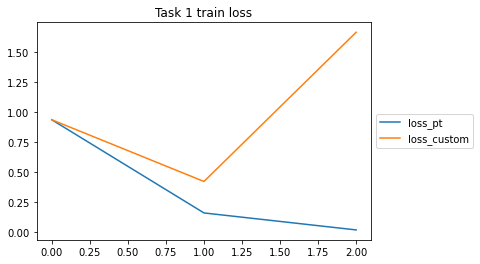

In [12]:
f = plt.figure()
plt.title('Task 1 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [13]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute((loss_history.iloc[:,0].values-loss_history.iloc[:,1].values)).sum()
if error < 1e-3:
    print('Задание 1 выполнено успешно')
else:
    print('Задание 1 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task1 = loss_history

Задание 1 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной
Суммарная ошибка = 1.9101


**Вывод.** Лоссы не сходятся, но в целом лосс у кастомной модели тоже уменьшается, так что непонятно...

### Задание 2

Требуется реализовать классы пакетной нормализации **BatchNorm2d** и слоя выборки усреднением **AvgPool**. Реализовать класс модели, идентичной эталонной TorchGradientModel2

Эталонная модель **TorchGradientModel2** состоит из:
- Сверточный слой с 4 фильтрами размера $3\times3$;
- Пакетная нормализация;
- Функция активации [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Выборки усреднением с ашгом 2 и размером окна 2
- Линейный слой с переменных количеством выходных нейронов

In [8]:
class TorchGradientModel2(nn.Module):
    def __init__(self, num_classes=2, input_size=5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(4)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * int((input_size - 2) / 2) * int((input_size - 2) / 2), num_classes)
        # PyTorch автоматически применяет LogSoftmax при использовании CrossEntropyloss

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [17]:
from torchsummary import summary

summary(TorchGradientModel2(), (1, 5, 5));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 4, 3, 3]             40
├─BatchNorm2d: 1-2                       [-1, 4, 3, 3]             8
├─ReLU: 1-3                              [-1, 4, 3, 3]             --
├─AvgPool2d: 1-4                         [-1, 4, 1, 1]             --
├─Flatten: 1-5                           [-1, 4]                   --
├─Linear: 1-6                            [-1, 2]                   10
Total params: 58
Trainable params: 58
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


In [18]:
learning_rate = 1
epochs = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце 
# loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel2()

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной 
# воспроизводимости результатов
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    if param[0] in ('conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias'):
#         print(param)
        torch_model_params.append(param[1].detach().clone())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты 
# по ошибкам на размер пакета (кол-во изображений для I-го слоя),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для эксперимента используется самый простой оптимизатор. 
# При желании можете поэкспериментировать с другими, которые реализовали 
# для 1-го задания
optimizer = torch.optim.SGD(torch_grad_model.parameters(), 
                            lr=learning_rate, momentum=0, dampening=0, 
                            weight_decay=0, nesterov=False)

torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(batch) # для обучения используем весь пакет
    
#     Можете выводить веса сети для прямого сравнения со своей реализацей, 
    for param in torch_grad_model.named_parameters():
        print(param)

    loss = ce(predict_y, labels)
    loss_history.loc[e, 'loss_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты так же можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item()

    train_acc /= batch.shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

 10%|█         | 1/10 [00:00<00:01,  4.83it/s, accuracy=1, loss=0.613]

('conv1.weight', Parameter containing:
tensor([[[[-0.0756,  0.1724, -0.1033],
          [-0.2789,  0.0732,  0.2076],
          [-0.3250,  0.0347,  0.0664]]],


        [[[ 0.0383, -0.0082, -0.1036],
          [-0.2588,  0.0544, -0.2239],
          [-0.2754, -0.1070, -0.2282]]],


        [[[ 0.1022,  0.2374,  0.2591],
          [-0.2066,  0.1817,  0.2369],
          [ 0.0037,  0.1406,  0.1886]]],


        [[[ 0.2550,  0.1784,  0.1423],
          [-0.1265, -0.1858, -0.1581],
          [ 0.2743, -0.0807,  0.0119]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([-0.3109, -0.0148, -0.0940, -0.2151], requires_grad=True))
('bn1.weight', Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True))
('bn1.bias', Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[ 0.3872, -0.4048, -0.0715, -0.0355],
        [-0.4527,  0.3023, -0.1591,  0.2246]], requires_grad=True))
('fc1.bias', Parameter containing:
tens

100%|██████████| 10/10 [00:00<00:00, 33.81it/s, accuracy=1, loss=0.0289]

('conv1.weight', Parameter containing:
tensor([[[[-0.0259,  0.2685,  0.0250],
          [-0.5487, -0.1588,  0.0036],
          [-0.2229,  0.1935,  0.2502]]],


        [[[ 0.2197, -0.0151,  0.0407],
          [-0.2041, -0.0917, -0.1982],
          [-0.2890, -0.3256, -0.2662]]],


        [[[ 0.0895,  0.2329,  0.2510],
          [-0.2041,  0.1931,  0.2436],
          [ 0.0012,  0.1471,  0.1910]]],


        [[[ 0.2148,  0.1432,  0.1071],
          [-0.1541, -0.2073, -0.1802],
          [ 0.3285, -0.0178,  0.0750]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([-0.3109, -0.0148, -0.0940, -0.2151], requires_grad=True))
('bn1.weight', Parameter containing:
tensor([1.1520, 0.8936, 1.0176, 1.0089], requires_grad=True))
('bn1.bias', Parameter containing:
tensor([ 0.0831, -0.0773,  0.0192,  0.0311], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[ 0.5683, -0.2543,  0.1292, -0.0695],
        [-0.6337,  0.1518, -0.3597,  0.2587]], requires_grad=True))
('f

limit_output extension: Maximum message size of 10000 exceeded with 11650 characters

Найдём формулы для `backward()` при подаче на вход строчного вектора $\vec{x}\in R^{1\times K}$. В [оригинальной статье](https://arxiv.org/pdf/1502.03167.pdf) на странице 4 есть все формулы для реализации backward pass. Сначала распишем, что мы вообще считаем в фазе тренировки:

### Forward
#### BatchNorm
$$
\vec{\widehat{x}} = \frac{\vec{x} - \widehat{\mu}}{\sqrt{\widehat{\sigma}^2 + \varepsilon}},\\
\vec{\widehat{\mu}} = \frac{1}{N}\sum\limits_{i=1}^N \vec{x}_i,\ \widehat{\sigma} = \frac{1}{N}\sum\limits_{i=1}^N \big(\vec{x} - \vec{\widehat{\mu}}\big)^2.\\
$$
#### Scaling
$$
x \in \mathbb{R}^{N \times K},
\gamma \in \mathbb{R}^{1 \times K},
\beta \in \mathbb{R}^{1 \times K}, \\
\text{Scaling}(x) = \gamma x + \beta,\ 
\text{Scaling}(x) \in \mathbb{R}^{N \times K}
$$
где $\gamma$ и $\beta$ &mdash; обучаемые параметры слоя.

### Backward
Теперь уже займёмся градиентами:
#### BatchNorm
$$
\frac{\partial \widehat{x}_i}{\partial x_i} = \frac{1}{\sqrt{\sigma^2 + \varepsilon}},
\\
\frac{\partial \mu}{\partial x_i} = \frac{1}{N},
\\
\frac{\partial \sigma^2}{\partial x_i} = \frac{2(x_i - \mu)}{N},
\\
\frac{\partial L}{\partial \mu} = \sum\limits_{i=1}^N \frac{\partial L}{\partial \widehat{x}_i} \frac{-1}{\sqrt{\sigma^2 + \varepsilon}}, 
\\
\frac{\partial L}{\partial \sigma^2} = \sum_{i=1}^N\frac{\partial L}{\partial \widehat{x}_i}\cdot\bigg(-0.5(x_i - \mu)(\sigma^2 + \varepsilon)^{-3/2}\bigg),
\\
\frac{\partial L}{\partial x_j} = \frac{\partial L}{\partial \widehat{x}_j} \cdot \frac{1}{\sqrt{\sigma^2 + \varepsilon}} + \frac{\partial L}{\partial \mu} \cdot \frac{1}{N} + \frac{\partial L}{\partial \sigma^2} \cdot \frac{2(x_i - \mu)}{N}.
% \\= \frac{1}{N \sqrt{\sigma^2 + \varepsilon}} \bigg(N \frac{\partial L}{\partial \widehat{x}_j} - \sum\limits_{i=1}^N \frac{\partial L}{\partial \widehat{x}_j} - \widehat{x}_i \sum\limits_{i=1}^N \frac{\partial L}{\partial \widehat{x}_j}\cdot \widehat{x}_j\bigg).
$$
#### Scaling
$$
\frac{\partial L}{\partial \widehat{x}_i} = \sum_{i=1}^N \frac{\partial L}{\partial y_i} \gamma, \\
\frac{\partial L}{\partial \gamma} = \sum_{i=1}^N \frac{\partial L}{\partial y_i} \widehat{x}_i, \\
\frac{\partial L}{\partial \beta} = \sum_{i=1}^N \frac{\partial L}{\partial y_i}.
$$

In [ ]:
from Task2Modules.OtherLayers import BatchNorm

Теперь разберёмся с average pooling. Если расписать на листочке для простых примеров формулы, то становится понятно, что `backward()` очень похож на `backward()` в свёрточном слое, только теперь нет параметров (то есть не нужно считать градиент по параметрам), все значения фильтра одинаковые (то есть вращать ничего не надо), паддинга нет (то есть не надо делать дополнительные расширения границ). Таким образом, из преобразований остаётся только раздвижение строк и столбцов друг от друга на `self.s - 1` с помощью функции `delate()`.

In [20]:
from Task2Modules.CNN import AvgPool

ImportError: cannot import name 'AvgPool' from 'Task2Modules.CNN' (/home/topcoder2k/CodeProjects/PythonProjects/scidev-TopCoder2K/Task2Modules/CNN.py)

In [ ]:
from Task2Modules.CustomModels import CustomModel2

In [ ]:
def train_custom_model2(X, y, epochs, num_classes):
    y = one_hot_encoding(labels, num_classes) # преобразуем число в эталоне в унитарный код.
    
    model = CustomModel2(input_size = X.shape[-1], num_classes=num_classes)
    cost = CrossEntropyLoss()
    
    params = model.get_params()

    optimizer = SGD(lr = learning_rate, params = model.get_params())      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0 
  
        y_pred = model.forward(X)
        loss, deltaL = cost.get(y_pred, y)
        grads = model.backward(deltaL)
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item() / X.shape[0]
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [ ]:
train_custom_model2(batch, labels, epochs, num_classes=2)

In [ ]:
f = plt.figure()
plt.title('Task 2 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute((loss_history.iloc[:,0].values-loss_history.iloc[:,1].values)).sum()
if error < 1e-3:
    print('Задание 2 выполнено успешно')
else:
    print('Задание 2 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task2 = loss_history

### Задание 3

Обучить ранее реализованную сеть **CustomModel2** на реальных данных из выборки digits.

In [ ]:
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torchvision

In [ ]:
def get_data_numbers():
    # Загружаем выборку digits
    digits = load_digits(n_class=10, return_X_y=False, as_frame=False)

    # ПРОВЕСТИ НЕОБХОДИМЫЕ ПРЕОБРАЗОВАНИЯ
    
    return train_x, train_label, val_x, val_label

In [ ]:
train_x, train_label, val_x, val_label = get_data_numbers()

In [ ]:
learning_rate = 1
epochs = 10
num_classes = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel2(num_classes, input_size=8)

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    if param[0] in ('conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias'):
#         print(param)
        torch_model_params.append(param[1].clone().detach())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам на размер пакета (кол-во изображений для I-го слоя),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для эксперимента используется самый простой оптимизатор. При желании можете поэкспериментировать с другими, которые реализовали для 1-го задания
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False)

torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(train_x[0:10]) # для обучения используем весь пакет
    
#     Можете выводить веса сети для прямого сравнения со своей реализацей, 
#     for param in torch_grad_model.named_parameters():
#         print(param)

    loss = ce(predict_y, train_label[0:10])
    loss_history.loc[e, 'loss_train_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты так же можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == train_label[0:10]).item()

    train_acc /= train_x[0:10].shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

In [ ]:
def train_model(epochs, learning_rate, loss_history, train_x, train_label, val_x, val_label):
    raise NotImplementedError

In [ ]:
# loss_history = pd.DataFrame(index=range(epochs), dtype=float)
train_model(epochs, learning_rate, loss_history, train_x[0:10], train_label[0:10], val_x[0:10], val_label[0:10])

f = plt.figure()
plt.title('Task 2 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute(loss_history[['loss_train_custom']].to_numpy()-loss_history[['loss_train_pt']].to_numpy()).sum()
if error < 1e-3:
    print('Задание 3 выполнено успешно')
else:
    print('Задание 3 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task2 = loss_history

### Необязательное задание
Создать свою архитектуру свёрточной сети и обучиться на полной выборке digits, получив высокое качество классификации. Сравнить скорость и финальное качество обучения при применении разных алгоритмов обучения (SGD с моментом, Adam), регуляризации весов.